In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/hindcast/'

In [5]:
f = pd.read_excel('/ocean/vdo/MEOPAR/2016_Nutrients_20180110_CN_edits.xlsx')
f.keys()

Index(['Crew', 'Date', 'Time of Sample', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Station', 'Depth', 'NO3+NO', 'PO4',
       'Samples missing!', 'Unnamed: 12', 'Samples in lab.'],
      dtype='object')

In [6]:
f = f.drop(f.keys()[11:], axis=1)

In [7]:
f.shape

(1553, 11)

In [8]:
f = f.dropna(subset = ['Date', 'Time of Sample', 'Latitude', 'Longitude', 'Depth', 'NO3+NO'])

In [9]:
f[:5]

,Crew,Date,Time of Sample,Lat_reported,Long_reported,Latitude,Longitude,Station,Depth,NO3+NO,PO4
0,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,18.491,1.951
1,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,18.662,1.863
2,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,19.621,1.561
7,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,0,24.163,2.237
8,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,20,24.326,2.787


In [10]:
local = pytz.timezone ("America/Los_Angeles")

In [11]:
import datetime

In [12]:
datetimes = np.array([])
for index in f.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(f['Date'][index])), 
                          f['Time of Sample'][index])
    datetimes = np.append(datetimes, dt)

In [13]:
f.shape

(1374, 11)

In [14]:
datetimes.shape

(1374,)

In [15]:
f = f.assign(datetime = datetimes)

In [16]:
f.shape

(1374, 12)

In [17]:
f.Crew.unique()

array(['Sentry Shoal', 'Campbell River', 'Lund', 'Powell River',
       'Steveston', 'Nanaimo/Qualicum', 'Baynes Sound', 'Cowichan Bay',
       'Galiano Island', 'Ladysmith', 'Irvines-Sechelt', 'Malaspina Strait'], dtype=object)

In [18]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_model_ni = np.array([])
list_of_depths = np.array([])
cb_lons = np.array([])
cb_lats = np.array([])
cb_datetimes = np.array([])
cb_cs_ni = np.array([])
cb_model_ni = np.array([])
cb_depths = np.array([])
for n in f.index:
    Yind, Xind = geo_tools.find_closest_model_point(f.Longitude[n], 
                                                        f.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if f['Depth'][n] == 0:
        depth = 0
    elif f['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(f['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            ni_val = ((1-delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))

        list_of_lons = np.append(list_of_lons, f.Longitude[n])
        list_of_lats = np.append(list_of_lats, f.Latitude[n])
        list_of_datetimes = np.append(list_of_datetimes, date)
        if f['NO3+NO'][n] == '<0':
            list_of_cs_ni = np.append(list_of_cs_ni, 0)
        else:
            list_of_cs_ni = np.append(list_of_cs_ni, float(f['NO3+NO'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_depths = np.append(list_of_depths, depth)
        if f.Crew[n] == 'Cowichan Bay':
            cb_lons = np.append(cb_lons, f.Longitude[n])
            cb_lats = np.append(cb_lats, f.Latitude[n])
            cb_depths = np.append(cb_depths, depth)
            cb_datetimes = np.append(cb_datetimes, date)
            if f['NO3+NO'][n] == '<0':
                cb_cs_ni = np.append(cb_cs_ni, 0)
            else:
                cb_cs_ni = np.append(cb_cs_ni, float(f['NO3+NO'][n]))
            cb_model_ni = np.append(cb_model_ni, ni_val)

In [19]:
list_of_lats.shape

(1363,)

In [20]:
list_of_model_ni.shape

(1363,)

In [21]:
cb_cs_ni.shape

(143,)

In [24]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

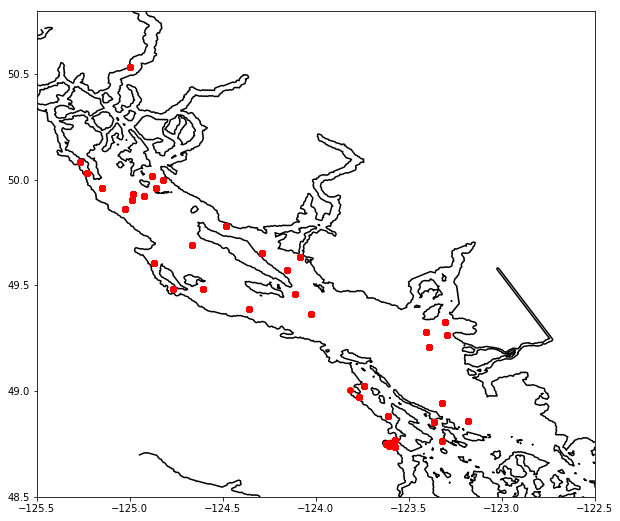

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.8)
ax.set_xlim(-125.5, -122.5);

In [24]:
list_of_cs_ni.shape

(1363,)

surface bias =  -0.755682048901
surface RMSE = 6.6327587605
surface Willmott = 0.790457644711
20m bias =  0.0675397119496
20m RMSE = 8.99962200653
20m Willmott = 0.531606224414
bias =  -0.352828846783
RMSE = 7.88033810241
Willmott = 0.785308948087


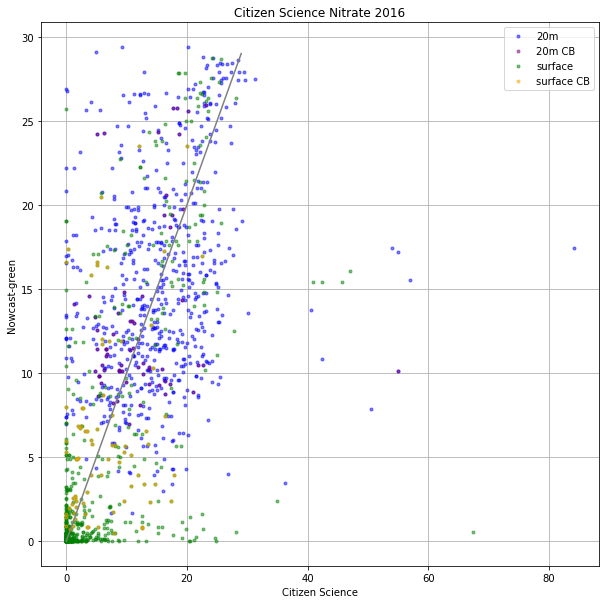

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_ni[list_of_depths == 18], list_of_model_ni[list_of_depths == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(cb_cs_ni[cb_depths == 18], cb_model_ni[cb_depths == 18],  
        '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax.plot(list_of_cs_ni[list_of_depths == 0], list_of_model_ni[list_of_depths==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(cb_cs_ni[cb_depths == 0], cb_model_ni[cb_depths == 0],  
        '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax.plot(np.arange(0,30), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Nitrate 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 0]) 
                               + np.mean(list_of_model_ni[list_of_depths == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 0] 
                                              - list_of_cs_ni[list_of_depths == 0])**2) /
                              len(list_of_cs_ni[list_of_depths == 0]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 0] 
                                             - list_of_cs_ni[list_of_depths == 0])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 0] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 18]) 
                               + np.mean(list_of_model_ni[list_of_depths == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 18] 
                                              - list_of_cs_ni[list_of_depths == 18])**2) /
                              len(list_of_cs_ni[list_of_depths == 18]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 18] 
                                             - list_of_cs_ni[list_of_depths == 18])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 18] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

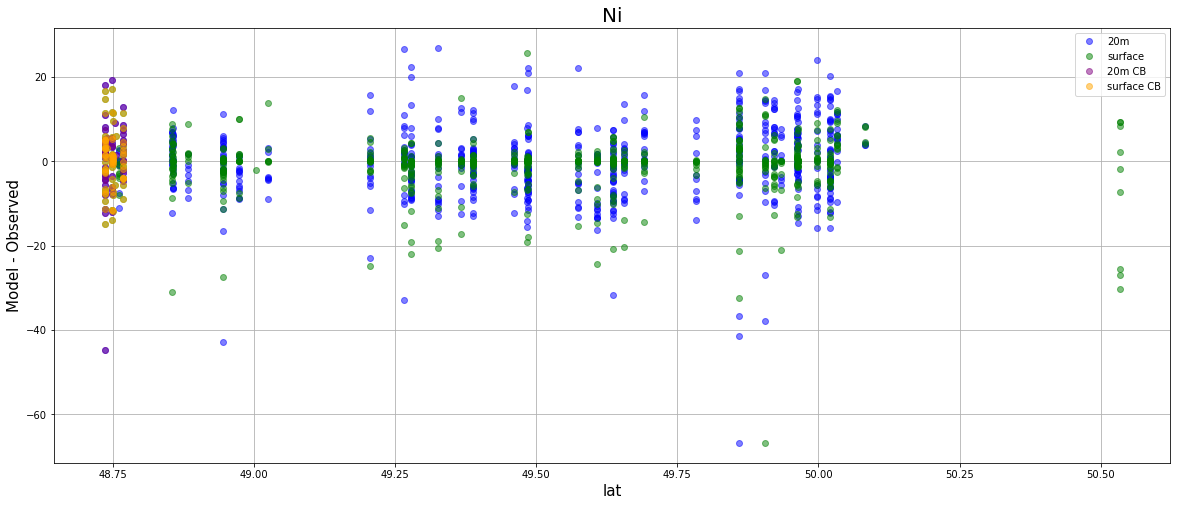

In [26]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lats[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lats[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

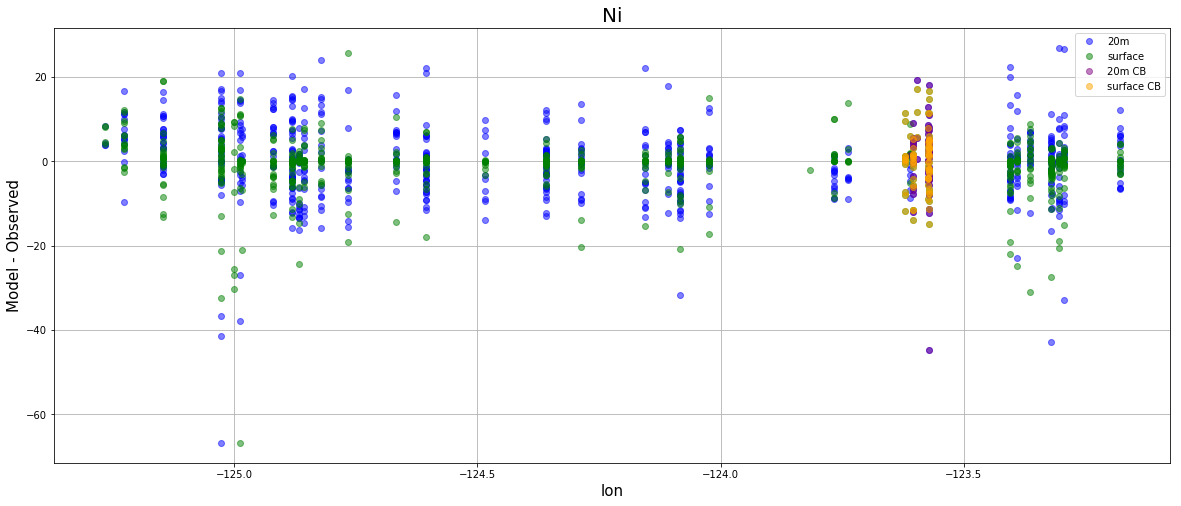

In [27]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lons[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lons[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

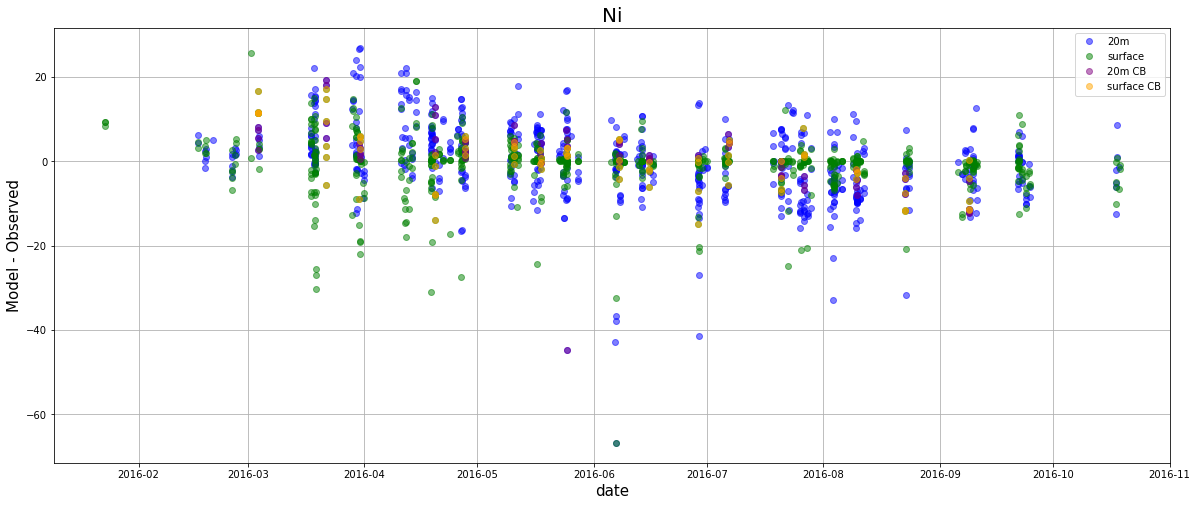

In [28]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_datetimes[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_datetimes[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

In [29]:
g = pd.read_excel('/ocean/vdo/MEOPAR/2016_Nutrients_20180110_CN_edits.xlsx', sheetname =1)
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time of Sample', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'Date doesn't match', 'Unnamed: 10'],
      dtype='object')

In [30]:
g[:5]

,Site ID,DDMMYYYY,Time of Sample,Lat_reported,Long_reported,Latitude,Longitude,Depth,SiO2 µM,Date doesn't match,Unnamed: 10
0,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,42.35500,NaN,NaN
1,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,4.91890,NaN,NaN
2,BS-1,2016-06-28,14:56:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,38.35056,NaN,NaN
3,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.16012,NaN,NaN
4,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.37894,NaN,NaN


In [31]:
g['Site ID'].unique()

array(['BS-1', 'BS-3', 'BS-6', 'BS-7', 'CBC-2', 'CBC-3', 'CBE-2', 'CBW-2',
       'CR-11', 'CR-2', 'CR-4', 'CR-8', 'GO-1', 'GO-3', 'GO-5', 'GO-7',
       'IS-2', 'IS-3', 'IS-4', 'LD-1', 'LD-2', 'LD-3', 'LS-2', 'LS-3',
       'LS-5', 'MAL-4', 'NQ-1', 'NQ-4', 'NQ-6', 'PR-6', 'PR-7', 'PR-8',
       'SN-001', 'SN-2', 'SN-5', 'SN-7', 'SN-8', 'SS-46131'], dtype=object)

In [32]:
g.shape

(842, 11)

In [33]:
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time of Sample', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'Date doesn't match', 'Unnamed: 10'],
      dtype='object')

In [34]:
g = g.drop(g.keys()[9:], axis=1)
g.shape

(842, 9)

In [35]:
g = g.dropna(subset = ['DDMMYYYY', 'Time of Sample', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM'])
g.shape

(826, 9)

In [36]:
g.Depth.unique()

array([20, 'S', 10, 5, 0, 30], dtype=object)

In [37]:
g.loc[g['Longitude'] < -200, 'Longitude'] = -123.31833333

In [38]:
g.loc[g['Latitude'] < 30, 'Latitude'] = 48.7616666666667

In [39]:
datetimes = np.array([])
for index in g.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(g['DDMMYYYY'][index])), 
                          g['Time of Sample'][index])
    datetimes = np.append(datetimes, dt)
g = g.assign(datetime = datetimes)

In [40]:
g.shape

(826, 10)

In [41]:
list_of_lons2 = np.array([])
list_of_lats2 = np.array([])
list_of_datetimes2 = np.array([])
list_of_cs_si = np.array([])
list_of_model_si = np.array([])
list_of_depths2 = np.array([])
cb_lons2 = np.array([])
cb_lats2 = np.array([])
cb_datetimes2 = np.array([])
cb_cs_si = np.array([])
cb_model_si = np.array([])
cb_depths2 = np.array([])
for n in g.index:
    Yind, Xind = geo_tools.find_closest_model_point(g.Longitude[n], g.Latitude[n], 
                                                    X, Y, land_mask = bathy.mask)
    if g['Depth'][n] == 0:
        depth = 0
    elif g['Depth'][n] == 20:
        depth = 18
    elif g['Depth'][n] == 10:
        depth = 9
    elif g['Depth'][n] == 5:
        depth = 4
    elif g['Depth'][n] == 30:
        depth = 21
    elif g['Depth'][n] == 'S':
        depth = 0
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(g['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            si_val = ((1-delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))

        list_of_lons2 = np.append(list_of_lons2, g.Longitude[n])
        list_of_lats2 = np.append(list_of_lats2, g.Latitude[n])
        list_of_datetimes2 = np.append(list_of_datetimes2, date)
        if g['SiO2 µM'][n] < 0:
            list_of_cs_si = np.append(list_of_cs_si, 0)
        else:
            list_of_cs_si = np.append(list_of_cs_si, float(g['SiO2 µM'][n]))
        list_of_model_si = np.append(list_of_model_si, si_val)
        list_of_depths2 = np.append(list_of_depths2, depth)
        if g['Site ID'][n][:2] == 'CB':
            cb_lons2 = np.append(cb_lons2, g.Longitude[n])
            cb_lats2 = np.append(cb_lats2, g.Latitude[n])
            cb_depths2 = np.append(cb_depths2, depth)
            cb_datetimes2 = np.append(cb_datetimes2, date)
            if g['SiO2 µM'][n] <0:
                cb_cs_si = np.append(cb_cs_si, 0)
            else:
                cb_cs_si = np.append(cb_cs_si, float(g['SiO2 µM'][n]))
            cb_model_si = np.append(cb_model_si, si_val)

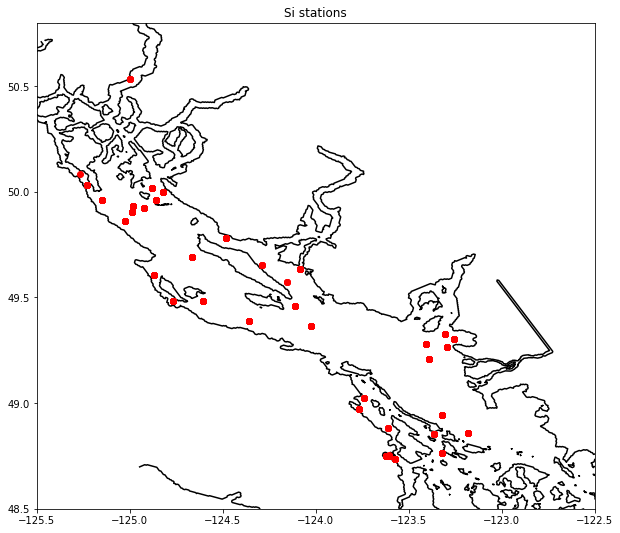

In [42]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons2, list_of_lats2, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_title('Si stations')
ax.set_ylim(48.5, 50.8)
ax.set_xlim(-125.5, -122.5);

surface bias =  -15.4438140672
surface RMSE = 21.2046528701
surface Willmott = 0.594962508155
20m bias =  -17.8008503742
20m RMSE = 21.6873565772
20m Willmott = 0.469780583013
bias =  -16.602119099
RMSE = 21.4284180754
Willmott = 0.623564439814


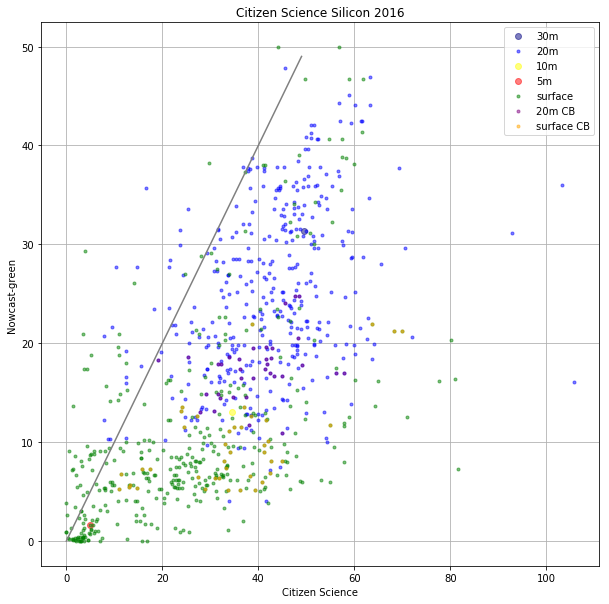

In [43]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_si[list_of_depths2 == 21], list_of_model_si[list_of_depths2 == 21],  
        'o', color = 'navy', alpha = 0.5, label = '30m')
ax.plot(list_of_cs_si[list_of_depths2 == 18], list_of_model_si[list_of_depths2 == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(list_of_cs_si[list_of_depths2 == 9], list_of_model_si[list_of_depths2 == 9],  
        'o', color = 'yellow', alpha = 0.5, label = '10m')
ax.plot(list_of_cs_si[list_of_depths2 == 4], list_of_model_si[list_of_depths2 == 4],  
        'ro', alpha = 0.5, label = '5m')
ax.plot(list_of_cs_si[list_of_depths2 == 0], list_of_model_si[list_of_depths2==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(cb_cs_si[cb_depths2 == 18], cb_model_si[cb_depths2 == 18],  
        '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax.plot(cb_cs_si[cb_depths2 == 0], cb_model_si[cb_depths2 == 0],  
        '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax.plot(np.arange(0,50), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Silicon 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths2 == 0]) 
                               + np.mean(list_of_model_si[list_of_depths2 == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths2 == 0] 
                                              - list_of_cs_si[list_of_depths2 == 0])**2) /
                              len(list_of_cs_si[list_of_depths2 == 0]))))
xbar = np.mean(list_of_cs_si[list_of_depths2 == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths2 == 0] 
                                             - list_of_cs_si[list_of_depths2 == 0])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths2 == 0] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths2 == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths2 == 18]) 
                               + np.mean(list_of_model_si[list_of_depths2 == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths2 == 18] 
                                              - list_of_cs_si[list_of_depths2 == 18])**2) /
                              len(list_of_cs_si[list_of_depths2 == 18]))))
xbar = np.mean(list_of_cs_si[list_of_depths2 == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths2 == 18] 
                                             - list_of_cs_si[list_of_depths2 == 18])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths2 == 18] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths2 == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

In [44]:
np.histogram(list_of_depths2, bins = [-1, 3, 7, 10, 20, 25])

(array([411,   1,   1, 403,   1]), array([-1,  3,  7, 10, 20, 25]))

# 411 samples at surface, 403 samples at 20m, 1 sample at 5, 10, and 30m

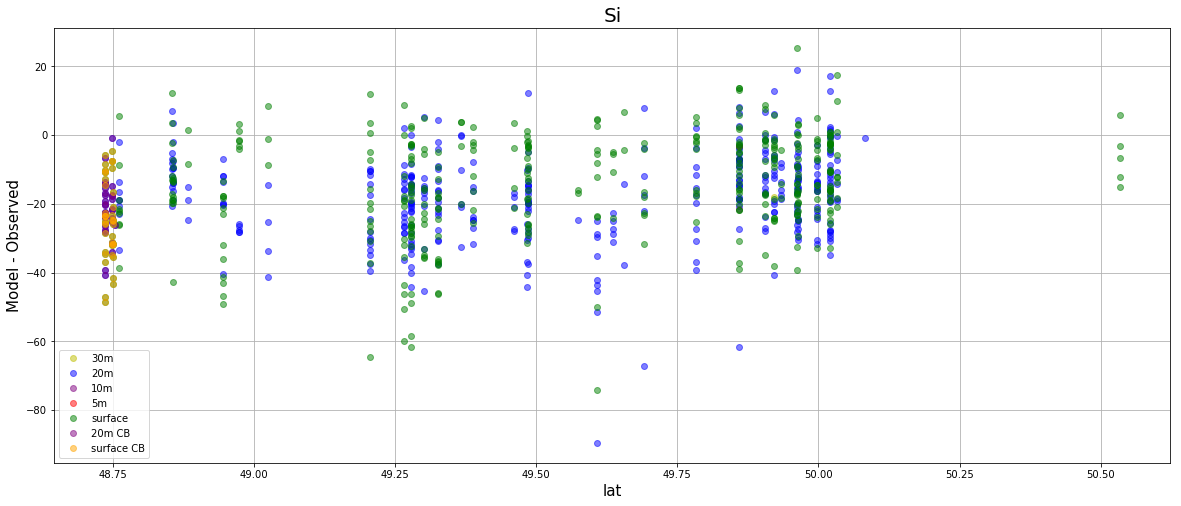

In [45]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_lats2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_lats2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_lats2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lats2[cb_depths2 == 18], 
        cb_model_si[cb_depths2 == 18] 
        - cb_cs_si[cb_depths2 == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lats2[cb_depths2 == 0], 
        cb_model_si[cb_depths2 == 0] 
        - cb_cs_si[cb_depths2 == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

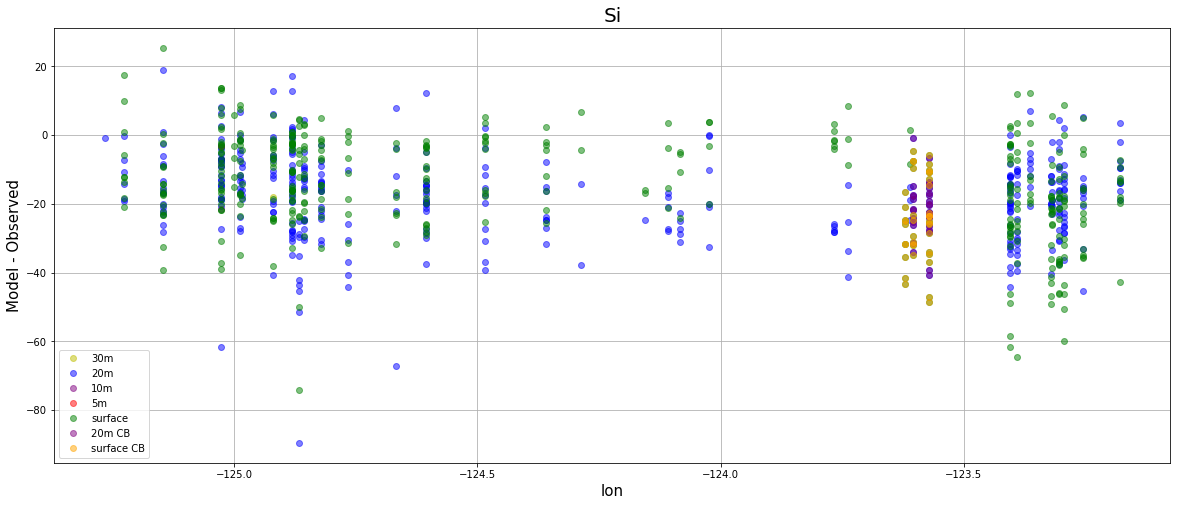

In [46]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_lons2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_lons2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_lons2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lons2[cb_depths2 == 18], 
        cb_model_si[cb_depths2 == 18] 
        - cb_cs_si[cb_depths2 == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lons2[cb_depths2 == 0], 
        cb_model_si[cb_depths2 == 0] 
        - cb_cs_si[cb_depths2 == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

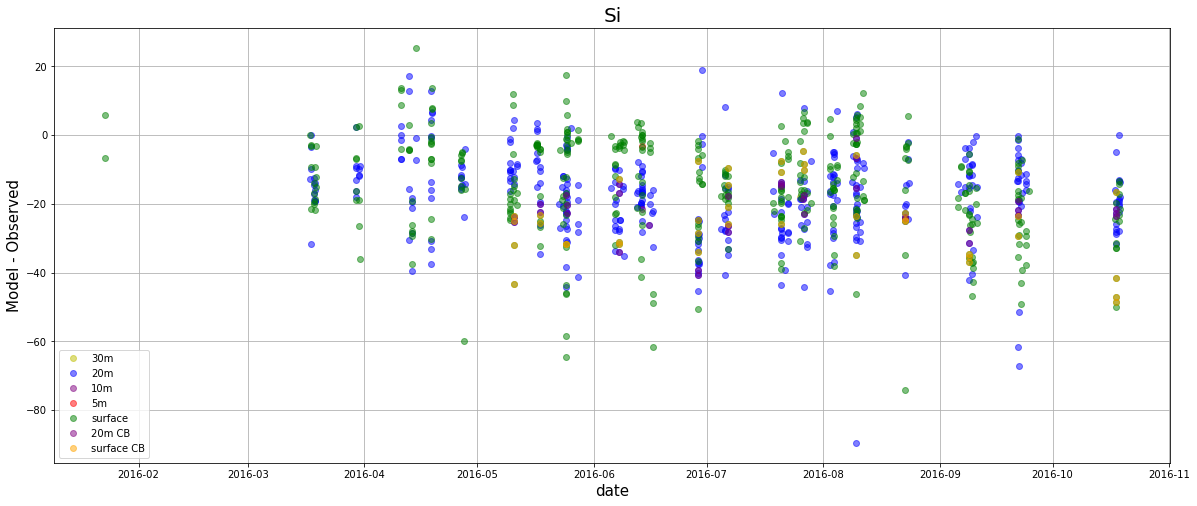

In [47]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_datetimes2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_datetimes2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_datetimes2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_datetimes2[cb_depths2 == 18], 
        cb_model_si[cb_depths2 == 18] 
        - cb_cs_si[cb_depths2 == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_datetimes2[cb_depths2 == 0], 
        cb_model_si[cb_depths2 == 0] 
        - cb_cs_si[cb_depths2 == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

In [48]:
f.keys()

Index(['Crew', 'Date', 'Time of Sample', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Station', 'Depth', 'NO3+NO', 'PO4',
       'datetime'],
      dtype='object')

In [49]:
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time of Sample', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'datetime'],
      dtype='object')

In [50]:
g.loc[g['Depth'] == 'S', 'Depth'] = 0

In [51]:
both = pd.merge(f, g, on=['datetime', 'Latitude', 'Longitude', 'Depth']).drop_duplicates()
both.shape

(1008, 18)

In [52]:
both[:5]

,Crew,Date,Time of Sample_x,Lat_reported_x,Long_reported_x,Latitude,Longitude,Station,Depth,NO3+NO,PO4,datetime,Site ID,DDMMYYYY,Time of Sample_y,Lat_reported_y,Long_reported_y,SiO2 µM
0,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.0,SS-46131,0,18.491,1.951,2016-01-22 17:30:00,SS-46131,2016-01-22,17:30:00,49° 92.000,125° 00.000,44.03363
1,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.0,SS-46131,0,18.491,1.951,2016-01-22 17:30:00,SS-46131,2016-01-22,17:30:00,49° 92.000,125° 00.000,56.75423
2,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.0,SS-46131,0,18.662,1.863,2016-01-22 17:30:00,SS-46131,2016-01-22,17:30:00,49° 92.000,125° 00.000,44.03363
3,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.0,SS-46131,0,18.662,1.863,2016-01-22 17:30:00,SS-46131,2016-01-22,17:30:00,49° 92.000,125° 00.000,56.75423
4,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.0,SS-46131,0,19.621,1.561,2016-01-22 17:30:00,SS-46131,2016-01-22,17:30:00,49° 92.000,125° 00.000,44.03363


In [53]:
list_of_cs_si3 = np.array([])
list_of_model_si3 = np.array([])
list_of_depths3 = np.array([])
list_of_cs_ni3 = np.array([])
list_of_model_ni3 = np.array([])
cb_cs_si3 = np.array([])
cb_cs_ni3 = np.array([])
cb_model_si3 = np.array([])
cb_model_ni3 = np.array([])
cb_depths3 = np.array([])
for n in both.index:
    Yind, Xind = geo_tools.find_closest_model_point(both.Longitude[n], both.Latitude[n], 
                                                    X, Y, land_mask = bathy.mask)
    if both['Depth'][n] == 0:
        depth = 0
    elif both['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(both['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            si_val = ((1-delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
            ni_val = ((1-delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))

        if both['SiO2 µM'][n] < 0:
            list_of_cs_si3 = np.append(list_of_cs_si3, 0)
        else:
            list_of_cs_si3 = np.append(list_of_cs_si3, float(both['SiO2 µM'][n]))
        if both['NO3+NO'][n] == '<0':
            list_of_cs_ni3 = np.append(list_of_cs_ni3, 0)
        else:
            list_of_cs_ni3 = np.append(list_of_cs_ni3, float(both['NO3+NO'][n]))
        list_of_model_si3 = np.append(list_of_model_si3, si_val)
        list_of_model_ni3 = np.append(list_of_model_ni3, ni_val)
        list_of_depths3 = np.append(list_of_depths3, depth)
        if both.Crew[n] == 'Cowichan Bay':
            if both['NO3+NO'][n] == '<0':
                cb_cs_ni3 = np.append(cb_cs_ni3, 0)
            else:
                cb_cs_ni3 = np.append(cb_cs_ni3, float(both['NO3+NO'][n]))
            if both['SiO2 µM'][n] < 0:
                cb_cs_si3 = np.append(cb_cs_si3, 0)
            else:
                cb_cs_si3 = np.append(cb_cs_si3, float(both['SiO2 µM'][n]))
            cb_model_ni3 = np.append(cb_model_ni3, ni_val)
            cb_model_si3 = np.append(cb_model_si3, si_val)
            cb_depths3 = np.append(cb_depths3, depth)

In [54]:
list_of_cs_si3.shape

(1002,)

In [55]:
list_of_depths3[list_of_depths3 == 0].shape

(512,)

In [56]:
list_of_depths3[list_of_depths3 == 18].shape

(490,)

In [57]:
list_of_depths3.shape

(1002,)

In [58]:
list_of_model_ni3.shape

(1002,)

In [59]:
list_of_model_si3.shape

(1002,)

In [60]:
cb_cs_ni3.shape

(90,)

# 512 surface samples and 490 samples at 20m

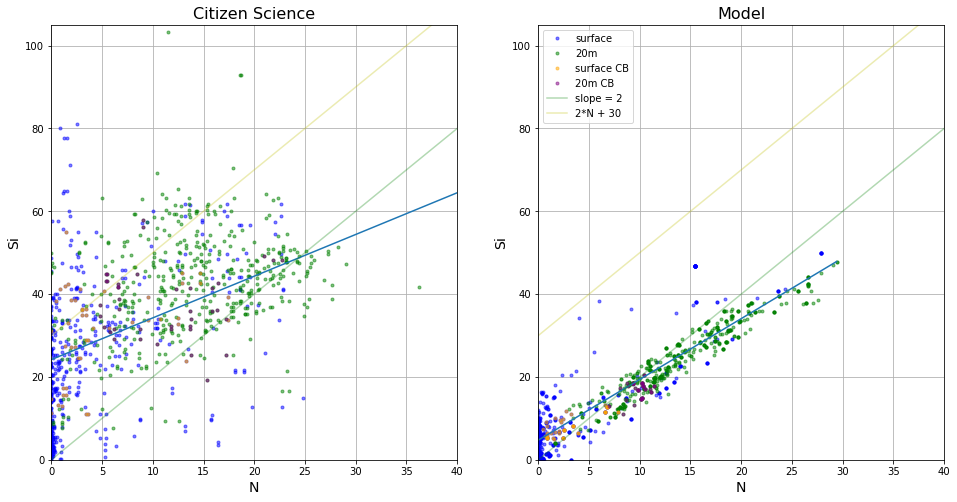

In [61]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(list_of_cs_ni3[list_of_depths3 == 0], list_of_cs_si3[list_of_depths3 == 0], 
           'b.', alpha = 0.5)
ax[0].plot(list_of_cs_ni3[list_of_depths3 == 18], list_of_cs_si3[list_of_depths3 == 18], 
           'g.', alpha = 0.5)
ax[0].plot(cb_cs_ni3[cb_depths3 == 0], cb_cs_si3[cb_depths3 == 0], 
           '.', color = 'orange', alpha = 0.5)
ax[0].plot(cb_cs_ni3[cb_depths3 == 18], cb_cs_si3[cb_depths3 == 18], 
           '.', color = 'purple', alpha = 0.5)
ax[0].plot(np.unique(list_of_cs_ni3), 
           np.poly1d(np.polyfit(list_of_cs_ni3, list_of_cs_si3, 1))(np.unique(list_of_cs_ni3)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni3[list_of_depths3 == 0], 
           list_of_model_si3[list_of_depths3 == 0], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni3[list_of_depths3 == 18], 
           list_of_model_si3[list_of_depths3 == 18], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(cb_model_ni3[cb_depths3 == 0], cb_model_si3[cb_depths3 == 0], 
           '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax[1].plot(cb_model_ni3[cb_depths3 == 18], cb_model_si3[cb_depths3 == 18], 
           '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax[1].plot(np.unique(list_of_model_ni3), 
           np.poly1d(np.polyfit(list_of_model_ni3, 
                                list_of_model_si3, 1))(np.unique(list_of_model_ni3)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [62]:
m1, b1 = np.polyfit(list_of_cs_ni3, list_of_cs_si3, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni3, list_of_model_si3, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.00695511681
CitSci y int = 24.1951758727
model slope = 1.46684849016
model y int = 4.74934935422


In [61]:
import pickle

In [87]:
output = open('model_si_2016.pkl', 'wb')
pickle.dump(list_of_model_si, output)
output.close()
output = open('model_ni_2016.pkl', 'wb')
pickle.dump(list_of_model_ni, output)
output.close()
output = open('cs_ni_2016.pkl', 'wb')
pickle.dump(list_of_cs_ni, output)
output.close()
output = open('cs_si_2016.pkl', 'wb')
pickle.dump(list_of_cs_si, output)
output.close()
output = open('cb_model_si_2016.pkl', 'wb')
pickle.dump(cb_model_si, output)
output.close()
output = open('cb_model_ni_2016.pkl', 'wb')
pickle.dump(cb_model_ni, output)
output.close()
output = open('cb_cs_ni_2016.pkl', 'wb')
pickle.dump(cb_cs_ni, output)
output.close()
output = open('cb_cs_si_2016.pkl', 'wb')
pickle.dump(cb_cs_si, output)
output.close()

In [88]:
output = open('model_si_2016b.pkl', 'wb')
pickle.dump(list_of_model_si3, output)
output.close()
output = open('model_ni_2016b.pkl', 'wb')
pickle.dump(list_of_model_ni3, output)
output.close()
output = open('cs_ni_2016b.pkl', 'wb')
pickle.dump(list_of_cs_ni3, output)
output.close()
output = open('cs_si_2016b.pkl', 'wb')
pickle.dump(list_of_cs_si3, output)
output.close()
output = open('cb_model_si_2016b.pkl', 'wb')
pickle.dump(cb_model_si3, output)
output.close()
output = open('cb_model_ni_2016b.pkl', 'wb')
pickle.dump(cb_model_ni3, output)
output.close()
output = open('cb_cs_ni_2016b.pkl', 'wb')
pickle.dump(cb_cs_ni3, output)
output.close()
output = open('cb_cs_si_2016b.pkl', 'wb')
pickle.dump(cb_cs_si3, output)
output.close()